Train data shape: (116, 9)
Test data shape: (30, 9)
Classes in y: [0 1]
Best LR for AdaGrad: 0.00390625 | Best Test Accuracy: 0.6333
Best LR for Adam: 0.015625 | Best Test Accuracy: 0.6667
Best LR for SGD: 0.125 | Best Test Accuracy: 0.6000


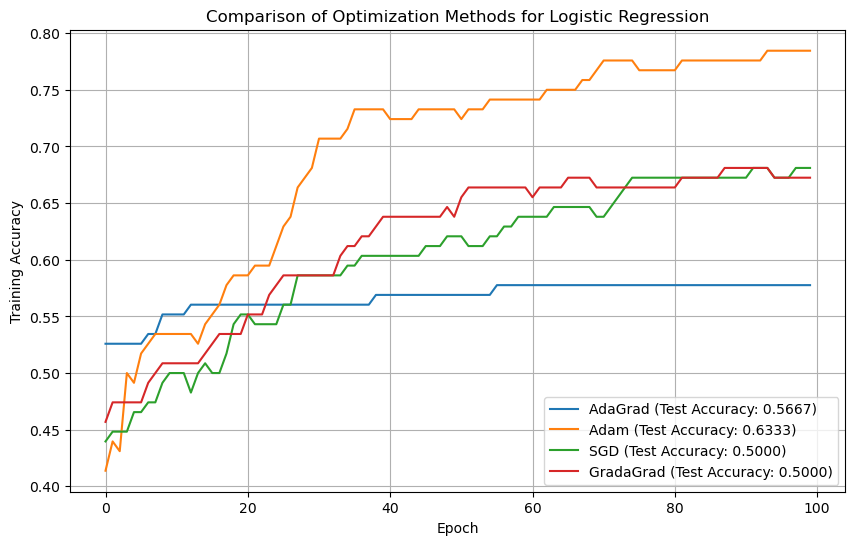

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import urllib.request
import os
from sklearn.metrics import accuracy_score
import import_ipynb
from Adagrad import Adagrad
from GradaGrad import GradaGrad
from Adam import Adam
from SGD import SGD

url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/glass.scale"
filename = "glass.scale"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

X, y = load_svmlight_file(filename)
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Classes in y: {np.unique(y)}")

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=100):
    model = LogisticRegressionModel(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optimizer_fn(model.parameters())

    accuracies = []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            predictions = (outputs >= 0.5).float()
            accuracy = accuracy_score(y_train, predictions.numpy())
            accuracies.append(accuracy)

    with torch.no_grad():
        model.eval()
        inputs_test = torch.tensor(X_test, dtype=torch.float32)
        outputs_test = model(inputs_test)
        predictions_test = (outputs_test >= 0.5).float()
        test_accuracy = accuracy_score(y_test, predictions_test.numpy())

    return accuracies, test_accuracy

def grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs):
    best_accuracy = 0
    best_lr = lr_range[0]

    for lr in lr_range:
        optimizer_fn = lambda params: optimizer_factory(params, lr=lr)
        _, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_lr = lr

    return best_lr, best_accuracy

epochs = 100
lr_range = [2**x for x in range(-10, 1)]  



optimizers_dict = {
    "AdaGrad": torch.optim.Adagrad,
    "Adam": Adam,
    "SGD": SGD,
    "GradaGrad": GradaGrad  
}

def make_optimizer_fn(name):
    if name == "GradaGrad":
        return lambda params: GradaGrad(params, gamma=1.0, rho=2.0, beta=0.9, G_inf=1, D_inf=100)
    else:
        return lambda params, lr: optimizers_dict[name](params, lr=lr)

plt.figure(figsize=(10, 6))

for name in optimizers_dict.keys():
    if name == "GradaGrad":
        optimizer_fn = make_optimizer_fn(name)
        accuracies, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)
    else:
        optimizer_factory = make_optimizer_fn(name)
        best_lr, best_accuracy = grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs)
        print(f"Best LR for {name}: {best_lr} | Best Test Accuracy: {best_accuracy:.4f}")
        optimizer_fn = lambda params: optimizer_factory(params, best_lr)
        accuracies, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)

    label = f'{name} (Test Accuracy: {test_accuracy:.4f})'
    plt.plot(range(epochs), accuracies, label=label)

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Optimization Methods for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()


Train data shape: (970, 16)
Test data shape: (243, 16)
Classes in y: [0 1]
Best LR for AdaGrad: 0.5 | Best Test Accuracy: 0.9712
Best LR for Adam: 0.25 | Best Test Accuracy: 0.9753
Best LR for SGD: 1 | Best Test Accuracy: 0.9465


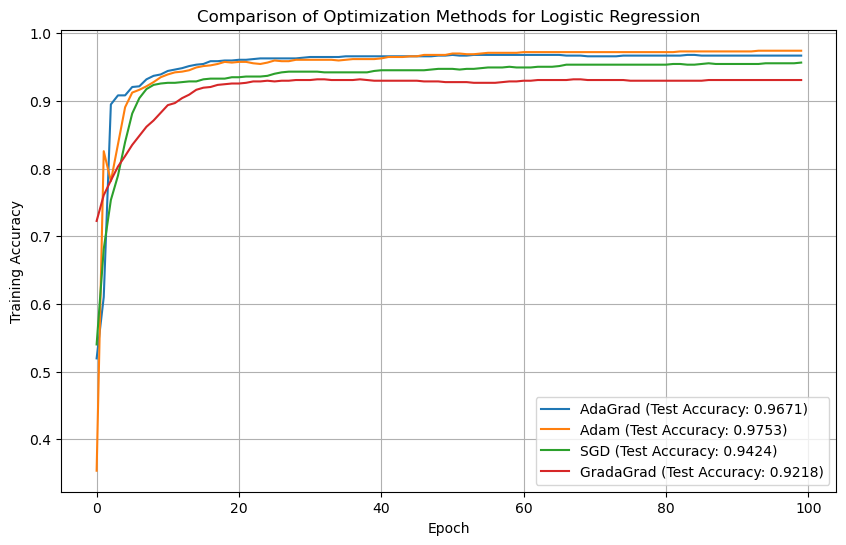

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import urllib.request
import os
from sklearn.metrics import accuracy_score

url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/letter.scale"
filename = "letter.scale"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

X, y = load_svmlight_file(filename)
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Classes in y: {np.unique(y)}")

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=100):
    model = LogisticRegressionModel(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optimizer_fn(model.parameters())

    accuracies = []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            predictions = (outputs >= 0.5).float()
            accuracy = accuracy_score(y_train, predictions.numpy())
            accuracies.append(accuracy)

    with torch.no_grad():
        model.eval()
        inputs_test = torch.tensor(X_test, dtype=torch.float32)
        outputs_test = model(inputs_test)
        predictions_test = (outputs_test >= 0.5).float()
        test_accuracy = accuracy_score(y_test, predictions_test.numpy())

    return accuracies, test_accuracy

def grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs):
    best_accuracy = 0
    best_lr = lr_range[0]

    for lr in lr_range:
        optimizer_fn = lambda params: optimizer_factory(params, lr=lr)
        _, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_lr = lr

    return best_lr, best_accuracy

epochs = 100
lr_range = [2**x for x in range(-10, 1)]  



optimizers_dict = {
    "AdaGrad": torch.optim.Adagrad,
    "Adam": Adam,
    "SGD": SGD,
    "GradaGrad": GradaGrad  
}

def make_optimizer_fn(name):
    if name == "GradaGrad":
        return lambda params: GradaGrad(params, gamma=1.0, rho=2.0, beta=0.9, G_inf=1, D_inf=100)
    else:
        return lambda params, lr: optimizers_dict[name](params, lr=lr)

plt.figure(figsize=(10, 6))

for name in optimizers_dict.keys():
    if name == "GradaGrad":
        optimizer_fn = make_optimizer_fn(name)
        accuracies, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)
    else:
        optimizer_factory = make_optimizer_fn(name)
        best_lr, best_accuracy = grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs)
        print(f"Best LR for {name}: {best_lr} | Best Test Accuracy: {best_accuracy:.4f}")
        optimizer_fn = lambda params: optimizer_factory(params, best_lr)
        accuracies, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)

    label = f'{name} (Test Accuracy: {test_accuracy:.4f})'
    plt.plot(range(epochs), accuracies, label=label)

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Optimization Methods for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()


Train data shape: (348, 18)
Test data shape: (87, 18)
Classes in y: [0 1]
Best LR for AdaGrad: 0.25 | Best Test Accuracy: 0.8966
Best LR for Adam: 0.5 | Best Test Accuracy: 0.9195
Best LR for SGD: 1 | Best Test Accuracy: 0.8736


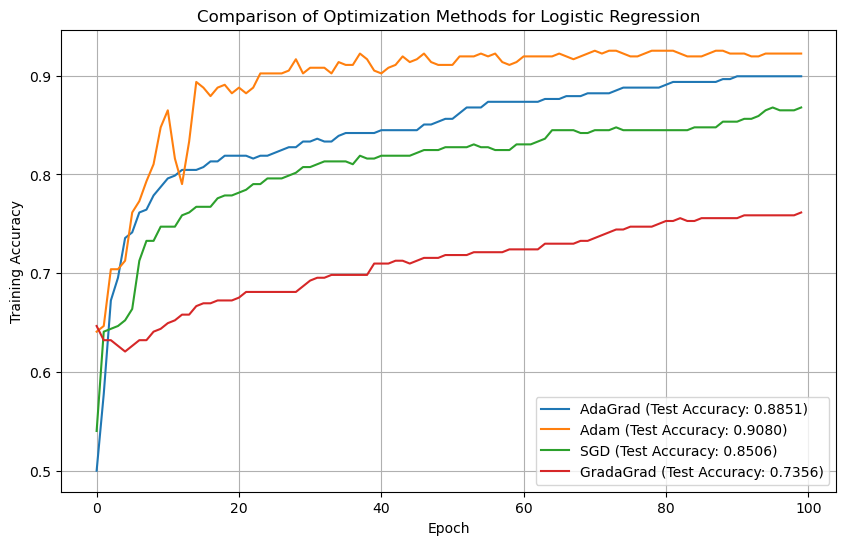

In [6]:
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/vehicle.scale"
filename = "vehicle.scale"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

X, y = load_svmlight_file(filename)
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Classes in y: {np.unique(y)}")

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=100):
    model = LogisticRegressionModel(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optimizer_fn(model.parameters())

    accuracies = []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            predictions = (outputs >= 0.5).float()
            accuracy = accuracy_score(y_train, predictions.numpy())
            accuracies.append(accuracy)

    with torch.no_grad():
        model.eval()
        inputs_test = torch.tensor(X_test, dtype=torch.float32)
        outputs_test = model(inputs_test)
        predictions_test = (outputs_test >= 0.5).float()
        test_accuracy = accuracy_score(y_test, predictions_test.numpy())

    return accuracies, test_accuracy

def grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs):
    best_accuracy = 0
    best_lr = lr_range[0]

    for lr in lr_range:
        optimizer_fn = lambda params: optimizer_factory(params, lr=lr)
        _, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_lr = lr

    return best_lr, best_accuracy

epochs = 100
lr_range = [2**x for x in range(-10, 1)]  



optimizers_dict = {
    "AdaGrad": torch.optim.Adagrad,
    "Adam": Adam,
    "SGD": SGD,
    "GradaGrad": GradaGrad  
}

def make_optimizer_fn(name):
    if name == "GradaGrad":
        return lambda params: GradaGrad(params, gamma=1.0, rho=2.0, beta=0.9, G_inf=1, D_inf=100)
    else:
        return lambda params, lr: optimizers_dict[name](params, lr=lr)

plt.figure(figsize=(10, 6))

for name in optimizers_dict.keys():
    if name == "GradaGrad":
        optimizer_fn = make_optimizer_fn(name)
        accuracies, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)
    else:
        optimizer_factory = make_optimizer_fn(name)
        best_lr, best_accuracy = grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs)
        print(f"Best LR for {name}: {best_lr} | Best Test Accuracy: {best_accuracy:.4f}")
        optimizer_fn = lambda params: optimizer_factory(params, best_lr)
        accuracies, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)

    label = f'{name} (Test Accuracy: {test_accuracy:.4f})'
    plt.plot(range(epochs), accuracies, label=label)

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Optimization Methods for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()


Train data shape: (76, 10)
Test data shape: (20, 10)
Classes in y: [0 1]
Best LR for AdaGrad: 0.25 | Best Test Accuracy: 1.0000
Best LR for Adam: 0.0625 | Best Test Accuracy: 1.0000
Best LR for SGD: 0.5 | Best Test Accuracy: 1.0000


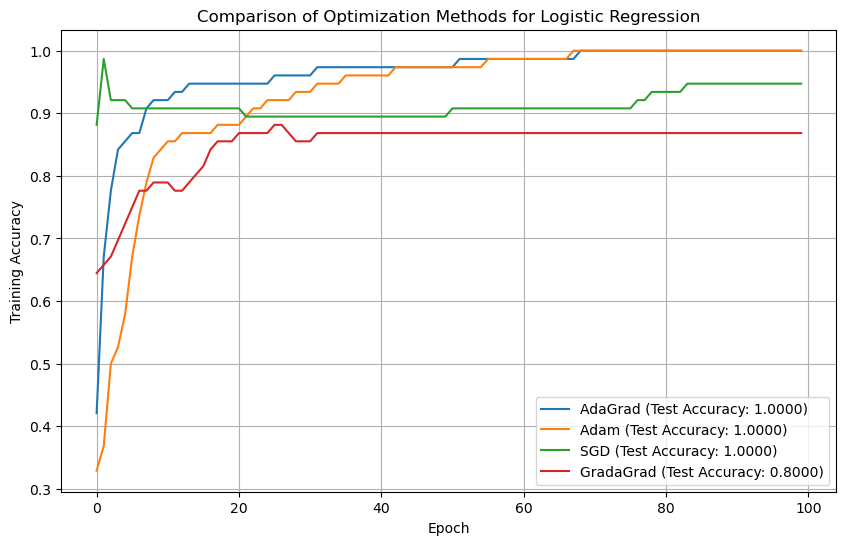

In [4]:
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/vowel.scale"
filename = "vowel.scale"
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

X, y = load_svmlight_file(filename)
y = y.astype(int)

class_0, class_1 = np.bincount(y).argsort()[-2:]
mask = np.isin(y, [class_0, class_1])
X, y = X[mask], y[mask]
X = X.toarray()
y = (y == class_1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Classes in y: {np.unique(y)}")

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=100):
    model = LogisticRegressionModel(X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optimizer_fn(model.parameters())

    accuracies = []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            predictions = (outputs >= 0.5).float()
            accuracy = accuracy_score(y_train, predictions.numpy())
            accuracies.append(accuracy)

    with torch.no_grad():
        model.eval()
        inputs_test = torch.tensor(X_test, dtype=torch.float32)
        outputs_test = model(inputs_test)
        predictions_test = (outputs_test >= 0.5).float()
        test_accuracy = accuracy_score(y_test, predictions_test.numpy())

    return accuracies, test_accuracy

def grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs):
    best_accuracy = 0
    best_lr = lr_range[0]

    for lr in lr_range:
        optimizer_fn = lambda params: optimizer_factory(params, lr=lr)
        _, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_lr = lr

    return best_lr, best_accuracy

epochs = 100
lr_range = [2**x for x in range(-10, 1)]  



optimizers_dict = {
    "AdaGrad": torch.optim.Adagrad,
    "Adam": Adam,
    "SGD": SGD,
    "GradaGrad": GradaGrad  
}

def make_optimizer_fn(name):
    if name == "GradaGrad":
        return lambda params: GradaGrad(params, gamma=1.0, rho=2.0, beta=0.9, G_inf=1, D_inf=100)
    else:
        return lambda params, lr: optimizers_dict[name](params, lr=lr)

plt.figure(figsize=(10, 6))

for name in optimizers_dict.keys():
    if name == "GradaGrad":
        optimizer_fn = make_optimizer_fn(name)
        accuracies, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)
    else:
        optimizer_factory = make_optimizer_fn(name)
        best_lr, best_accuracy = grid_search_optimizer(X_train, y_train, X_test, y_test, optimizer_factory, lr_range, epochs)
        print(f"Best LR for {name}: {best_lr} | Best Test Accuracy: {best_accuracy:.4f}")
        optimizer_fn = lambda params: optimizer_factory(params, best_lr)
        accuracies, test_accuracy = train_logistic_regression(X_train, y_train, X_test, y_test, optimizer_fn, epochs=epochs)

    label = f'{name} (Test Accuracy: {test_accuracy:.4f})'
    plt.plot(range(epochs), accuracies, label=label)

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Optimization Methods for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()